# 3.1 Parabolic model problem
In this unit we want to turn to instationary problems. And we will start with a very basic setup: implicit Euler time stepping for the convection diffusion equation. After the main part of this tutorial we have supplementary material to extend the case in several regards.



We are solving the unsteady heat equation 

$$\text{find } u:[0,T] \to H_{0,D}^1 \quad \int_{\Omega} \partial_t u v + a\int_{\Omega} \nabla u \nabla v + b \cdot \nabla u v = \int f v  \quad \forall v \in H_{0,D}^1, \quad u(t=0) = u_0$$

with a suitable advective field $b$ (the wind).

In [ ]:
#imports
from ngsolve import *
from netgen.geom2d import SplineGeometry
from ngsolve.webgui import Draw

* Geometry: $(-1,1)^2$
* Dirichlet boundaries everywhere
* Mesh

In [ ]:
from netgen.occ import *
from netgen.webgui import Draw as DrawGeo
shape = Rectangle(2,2).Face().Move((-1,-1,0))
shape.edges.Min(X).name="left"
shape.edges.Max(X).name="right"
shape.edges.Min(Y).name="bottom"
shape.edges.Max(Y).name="top"


In [ ]:
mesh = Mesh(OCCGeometry(shape, dim=2).GenerateMesh(maxh=0.25))
fes = H1(mesh, order=2, dirichlet="bottom|right|left|top")
u,v = fes.TnT()
time = 0.0
dt = 0.001

We define the field $b$ (the wind) as 

$$b(x,y) := (2y(1-x^2),-2x(1-y^2)).$$

In [ ]:
b = CoefficientFunction((2*y*(1-x*x),-2*x*(1-y*y)))
Draw(b,mesh,"wind", vectors={"grid_size": 32}, order=3)

* bilinear forms for 
 * convection-diffusion stiffness and 
 * mass matrix separately.
* non-symmetric memory layout for the mass matrix so that a and m have the same sparsity pattern.

In [ ]:
a = BilinearForm(fes, symmetric=False)
a += 0.01*grad(u)*grad(v)*dx + b*grad(u)*v*dx
a.Assemble()

m = BilinearForm(fes, symmetric=False)
m += u*v*dx
m.Assemble()

## Implicit Euler method
$$
  \underbrace{(M + \Delta t A)}_{M^\ast} u^{n+1} = M u^n + \Delta tf^{n+1}
$$

or in an incremental form:

$$
  M^\ast (u^{n+1} - u^n) = - \Delta t A u^n + \Delta tf^{n+1}.
$$

* Incremental form: $u^{n+1} - u^n$ has homogeneous boundary conditions (unless boundary conditions are time-dependent).
* For the time stepping method: set up linear combinations of matrices.
* (Only) if the sparsity pattern of the matrices agree we can copy the pattern and sum up the entries.

First, we create a matrix of same format as m.mat and compare number of non-zero entries and sparsity pattern:

In [ ]:
mstar = m.mat.CreateMatrix()
print(f"m.mat.nze = {m.mat.nze}, a.mat.nze={a.mat.nze}, mstar.nze={mstar.nze}")

To access the entries we use the vector of nonzero-entries:

In [ ]:
print(f"mstar.nze={mstar.nze}, len(mstar.AsVector())={len(mstar.AsVector())}")

In [ ]:
# print(mstar.AsVector())

Using the vector we can build the linear combination of the a and the m matrix:

In [ ]:
mstar.AsVector().data = m.mat.AsVector() + dt * a.mat.AsVector()
# corresponds to M* = M + dt * A
invmstar = mstar.Inverse(freedofs=fes.FreeDofs())

In [ ]:
gfu = GridFunction(fes)
scene = Draw(gfu,mesh,"u")

## Supplementary 2: time-dependent r.h.s. data <a class="anchor" id="TDRHS"></a>

Next: time-dependent r.h.s. data $f=f(t)$:

* Use `Parameter` t representing the time. 
* A `Parameter` is a constant `CoefficientFunction` the value of which can be changed with the `Set`-function.

In [ ]:
t = Parameter(0.0)

In [ ]:
gfu.space.globalorder

An example of a time-dependent coefficient that we want to use as r.h.s. in the following is

In [ ]:
omega=1
gausspt = exp(-6*((x+sin(omega*t))*(x+sin(omega*t))+y*y))-exp(-6*((x-sin(omega*t))*(x-sin(omega*t))+y*y))
gff = GridFunction(L2(mesh,order=gfu.space.globalorder+1))
gfft = GridFunction(gff.space,multidim=0)
time = 0.0
for i in range(7):
    t.Set(3*i/6)
    gff.Set(gausspt)
    gfft.AddMultiDimComponent(gff.vec)
Draw(gfft, mesh, interpolate_multidim=True, animate=True, autoscale=False, min=-1, max=1)

Accordingly, we define a different linear form which then has to be assembled in every time step.

In [ ]:
ft = LinearForm(fes)
ft += gausspt*v*dx

In [ ]:
print(2 / 0.001 / 10)

In [ ]:
def TimeStepping(invmstar, initial_cond = None, t0 = 0, tend = 2, 
                      nsamples = 10):
    if initial_cond:
        gfu.Set(initial_cond)
    cnt = 0; time = t0
    sample_int = int(floor(tend / dt / nsamples)+1)
    gfut = GridFunction(gfu.space,multidim=0)
    gfut.AddMultiDimComponent(gfu.vec)
    while time < tend - 0.5 * dt:
        t.Set(time)
        ft.Assemble()
        res = dt * ft.vec - dt * a.mat * gfu.vec
        gfu.vec.data += invmstar * res
        print("\r",time,end="")
        if cnt % sample_int == 0:
            gfut.AddMultiDimComponent(gfu.vec)
        cnt += 1; time = cnt * dt
    return gfut

In [38]:
%%time
gfut = TimeStepping(invmstar, initial_cond=CF(0),tend=2)
Draw(gfut, mesh, interpolate_multidim=True, animate=True, 
     min=-0.75,max=0.75,autoscale=False)

 1.113

 1.999

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

CPU times: user 377 ms, sys: 6.62 ms, total: 383 ms
Wall time: 380 ms


BaseWebGuiScene

In [39]:
def exact_TimeStepping_app2(invmstar, initial_cond = None, t0 = 0, tend = 2, 
                 nsamples = 10):
    if initial_cond:
        exact_gfu.Set(initial_cond)
    cnt = 0; time = t0
    sample_int = int(floor(tend / dt / nsamples)+1)
    exact_gfut_a2 = GridFunction(exact_gfu.space,multidim=0)
    exact_gfut_a2.AddMultiDimComponent(exact_gfu.vec)
    while time < tend - 0.5 * dt:
        t.Set(time)
        ft.Assemble()
        res = dt * ft.vec - dt * a.mat * exact_gfu.vec
        exact_gfu.vec.data += invmstar * res
        print("\r",time,end="")
        if cnt % sample_int == 0:
            exact_gfut_a2.AddMultiDimComponent(exact_gfu.vec)
        cnt += 1; time = cnt * dt
    return exact_gfut_a2

In [ ]:
mesh_e = Mesh(OCCGeometry(shape, dim=2).GenerateMesh(maxh=0.01))
fes = H1(mesh_e, order=1, dirichlet="bottom|right|left|top")
u,v = fes.TnT()
time = 0.0
dt = 0.001
b = CoefficientFunction((2*y*(1-x*x),-2*x*(1-y*y)))
a = BilinearForm(fes, symmetric=False)
a += 0.01*grad(u)*grad(v)*dx + b*grad(u)*v*dx
a.Assemble()

m = BilinearForm(fes, symmetric=False)
m += u*v*dx
m.Assemble()

mstar = m.mat.CreateMatrix()
mstar.AsVector().data = m.mat.AsVector() + dt * a.mat.AsVector()
# corresponds to M* = M + dt * A
invmstar = mstar.Inverse(freedofs=fes.FreeDofs())
omega=1
gausspt = exp(-6*((x+sin(omega*t))*(x+sin(omega*t))+y*y))-exp(-6*((x-sin(omega*t))*(x-sin(omega*t))+y*y))
ft = LinearForm(fes)
ft += gausspt*v*dx

exact_gfu = GridFunction(fes)

exact_gfut_a2 = exact_TimeStepping_app2(invmstar, initial_cond=(1-y*y)*x,tend=2)

 0.281000000000000024

In [59]:
Draw(exact_gfut_a2, mesh_e, interpolate_multidim=True, animate=True, 
     min=-0.75,max=0.75,autoscale=False)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

BaseWebGuiScene

In [42]:
err = sqrt (Integrate ( (gfut-exact_gfut_a2)*(gfut-exact_gfut_a2), mesh))
err

0.0

In [63]:
mesh_size = [0.5, 0.25, 0.125,  0.0625 ,0.03125] #, 0.015625]
dofs = []
errors = []

time = 0.0
dt = 0.001
omega=1
gausspt = exp(-6*((x+sin(omega*t))*(x+sin(omega*t))+y*y))-exp(-6*((x-sin(omega*t))*(x-sin(omega*t))+y*y))

for h in mesh_size:
    mesh = Mesh(OCCGeometry(shape, dim=2).GenerateMesh(maxh=h))
    fes = H1(mesh, order=1, dirichlet="bottom|right|left|top")
    dofs.append(fes.ndof)
    u,v = fes.TnT()
    b = CoefficientFunction((2*y*(1-x*x),-2*x*(1-y*y)))
    a = BilinearForm(fes, symmetric=False)
    a += 0.01*grad(u)*grad(v)*dx + b*grad(u)*v*dx
    a.Assemble()

    m = BilinearForm(fes, symmetric=False)
    m += u*v*dx
    m.Assemble()

    mstar = m.mat.CreateMatrix()
    mstar.AsVector().data = m.mat.AsVector() + dt * a.mat.AsVector()
    # corresponds to M* = M + dt * A
    invmstar = mstar.Inverse(freedofs=fes.FreeDofs())
    
    ft = LinearForm(fes)
    ft += gausspt*v*dx
    ft.Assemble()

    gfu = GridFunction(fes)

    gfut = TimeStepping(invmstar, initial_cond=(1-y*y)*x,tend=2) 
    Draw(gfut, mesh, interpolate_multidim=True, animate=True, 
     min=-0.75,max=0.75,autoscale=False)
        
    err = sqrt (Integrate ( (gfut-exact_gfut_a2)*(gfut-exact_gfut_a2), mesh))
    errors.append(err)

 1.999000000000000144

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

 1.999000000000000144

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

 1.999000000000000144

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

 1.999000000000000144

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

 1.999000000000000144

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

In [64]:
errors

[0.04538245253535865,
 0.009316366750343865,
 0.002056160387474862,
 0.0005793878651455117,
 0.00033949532998962887]

In [65]:
import numpy as np
for i in range(len(mesh_size)-1):
    print("Convergence rate:", np.log(errors[i+1]/errors[i])/np.log(mesh_size[i+1]/mesh_size[i]))

Convergence rate: 2.284295237245973
Convergence rate: 2.179814630127171
Convergence rate: 1.827351430174589
Convergence rate: 0.7711377394688712


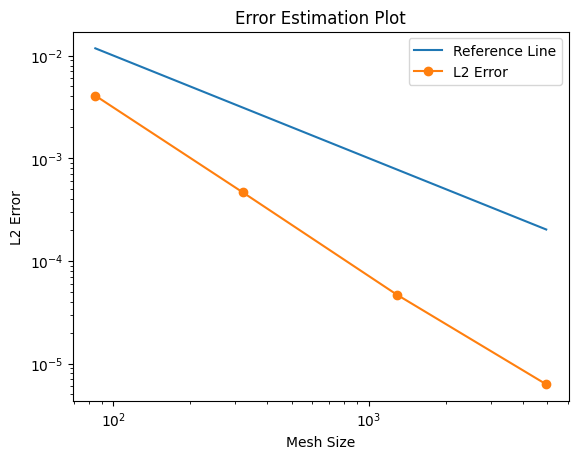

In [57]:
import matplotlib.pyplot as plt
plt.loglog(dofs, np.divide(np.ones(len(dofs)), np.array(dofs)), label="Reference Line")
plt.loglog(dofs,errors, "-o", label="L2 Error")
plt.title("Error Estimation Plot")
plt.xlabel("Mesh Size")
plt.ylabel("L2 Error")
plt.legend()
plt.show()

In [ ]:
Draw(gfut, mesh, interpolate_multidim=True, animate=True)